In [11]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


In [8]:
#import load boston dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [17]:

data.shape #total 506*13 筆數據
x_full , y_full = data , target
n_samples = x_full.shape[0]         #506
n_features = x_full.shape[1]        #13

In [21]:
#創造擁有50%數據缺失的數據集
rng = np.random.RandomState(0)
missing_rate = 0.5
n_missing_samples = int(np.floor(n_samples*n_features*missing_rate))

#每個缺失數據具備一個列和行索引
#randint(下限,上限,n) 請在下限～上限中取出n個整數
missing_features = rng.randint(0,n_features,n_missing_samples)
missing_samples = rng.randint(0,n_samples,n_missing_samples)

#將創造出來的缺失數據補到原本的數據集中
x_missing = x_full.copy()
y_missing = y_full.copy()
x_missing[missing_samples,missing_features] = np.nan #缺失值設為nan
x_missing = pd.DataFrame(x_missing) #設成表格
x_missing

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,65.2,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,78.9,4.9671,2.0,NaN,NaN,396.90,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,61.1,NaN,2.0,242.0,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.458,NaN,45.8,NaN,NaN,222.0,18.7,NaN,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,NaN,NaN,NaN,NaN,18.7,NaN,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,NaN,NaN,NaN,0.0,0.573,NaN,69.1,NaN,1.0,NaN,21.0,NaN,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,NaN,396.90,9.08
503,NaN,NaN,11.93,NaN,0.573,6.976,91.0,NaN,NaN,NaN,21.0,NaN,5.64
504,0.10959,0.0,11.93,NaN,0.573,NaN,89.3,NaN,1.0,NaN,21.0,393.45,6.48


In [22]:
#使用均值填補缺失值
imp_mean = SimpleImputer(missing_values=np.nan,strategy='mean')
x_missing_mean = imp_mean.fit_transform(x_missing)

#使用0填補缺失值
imp_0 = SimpleImputer(missing_values=np.nan,strategy="constant",fill_value=0)
x_missing_0 = imp_0.fit_transform(x_missing)

In [33]:
#使用隨機森林填補缺失值
#地區 ＆ 環境 => 預測房價
#地區 ＆ 房價 => 預測環境(缺失值)
#填缺失值的順序類似數獨，從缺失最少的開始填

x_missing_reg = x_missing.copy()
#缺失值排序 argsort 會返回對應之索引
sortindex = np.argsort(x_missing_reg.isnull().sum(axis=0)).values

for i in sortindex:
    
    #構建新的特徵矩陣和新標籤
    df = x_missing_reg
    fillc = df.iloc[:,i]    #取出要補缺失值的那列
    #pd.concat([要合併的所有data],axis = 1 (用行進行匹配，即補在最左邊))
    df = pd.concat([df.iloc[:,df.columns != i],pd.DataFrame(y_full)],axis=1)
    #新特徵矩陣對所有缺失值的列補0
    df_0 = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0).fit_transform(df)

    #找訓練集和測試集
    #X為已知的列
    #Y為要補缺失的列
    Ytrain = fillc[fillc.notnull()]
    Ytest = fillc[fillc.isnull()]
    Xtrain = df_0[Ytrain.index,:]
    Xtest = df_0[Ytest.index,:]

    #用隨機森林回歸填補缺失值

    rfc = RandomForestRegressor(n_estimators=100)
    rfc = rfc.fit(Xtrain,Ytrain)
    Ypredict = rfc.predict(Xtest)
    #將預測值填入該列   
    # iloc return indexs
    # loc return values
    x_missing_reg.loc[x_missing_reg.iloc[:,i].isnull(),i] = Ypredict



In [35]:
#對所有數據建立模型並取得MSE
#回歸的打分標準為neg_mean_squared_error
X = [x_full,x_missing_mean,x_missing_0,x_missing_reg]

mse=[]
std=[]

for x in X:
    estimator = RandomForestRegressor(random_state=0,n_estimators=100)
    scores = cross_val_score(estimator,x,y_full,scoring='neg_mean_squared_error',cv=5).mean()
    mse.append(scores*-1)

In [38]:
#查看各個回歸之分數，分數越小越好
[*zip(["x_full","x_missing_mean","x_missing_0","x_missing_reg"],mse)]

[('x_full', 21.571667100368845),
 ('x_missing_mean', 40.848037216676374),
 ('x_missing_0', 49.626793201980185),
 ('x_missing_reg', 18.30006171007571)]

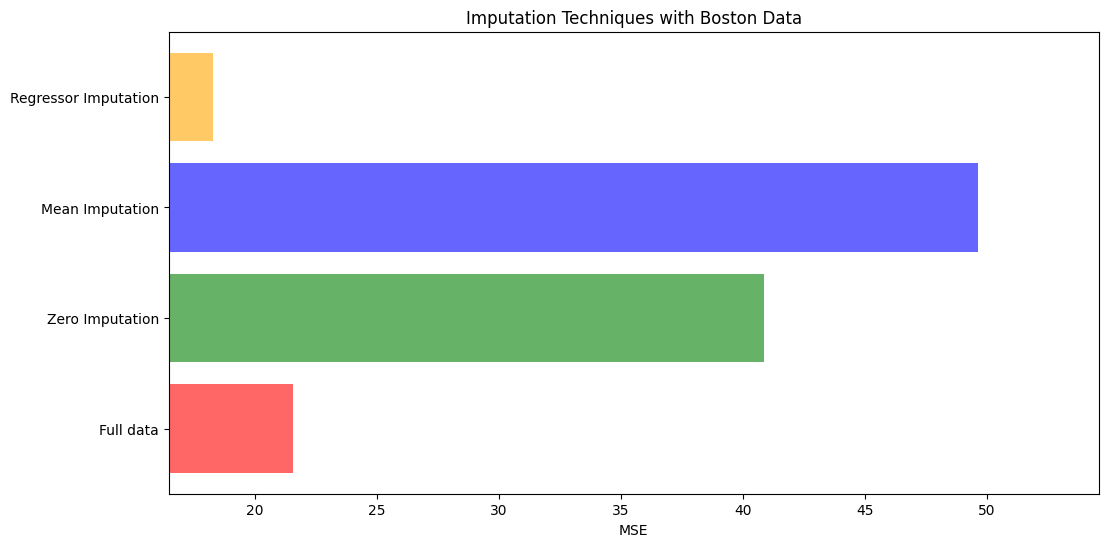

In [39]:
#畫圖
x_labels = ['Full data'
            ,'Zero Imputation'
            ,'Mean Imputation'
            ,'Regressor Imputation']
colors = ['r','g','b','orange']

plt.figure(figsize=(12,6))
ax = plt.subplot(111)   #添加子圖
for i in np.arange(len(mse)):
    ax.barh(i,mse[i],color=colors[i],alpha=0.6,align='center')
ax.set_title("Imputation Techniques with Boston Data")
#set_xlim利用左右比率設置邊界，其中0.9可以避免從0開始
ax.set_xlim(left=np.min(mse)*0.9
            ,right=np.max(mse)*1.1)
#set_yticks 代表刻度
ax.set_yticks(np.arange(len(mse)))
ax.set_xlabel('MSE')
ax.set_yticklabels(x_labels)
plt.show()
